# MIRA Lab 1
*Robert Martí and Sandra González-Villà*


---


## Intensity-based image registration
In this notebook you have the code of a fully working registration framework, implementing a rigid registration algorithm which minimizes the sum of squared distances (SSD). Read and understand the following functions and answer the questions asked through the notebook. Then, complete the assigned tasks.

In [1]:
from scipy.optimize import minimize
from scipy.ndimage import map_coordinates
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np

import cv2

In [2]:
def affine_transform_2d_double(Iin, M, order=3, mode=2, ImageSize=None):
    # Discussion Note:
    # From the package docx, the order of the spline interpolation, default is 3.
    # The order has to be in the range 0-5.

    boundaries = ['reflect', 'grid-mirror', 'constant', 'grid-constant',
                  'nearest', 'mirror', 'grid-wrap', 'wrap']

    if ImageSize is None:
        ImageSize = [Iin.shape[0], Iin.shape[1]]

    if order not in np.arange(6):
        raise ValueError('Invalid order value')

    if mode not in np.arange(8):
        raise ValueError('Invalid mode value')

    boundary = boundaries[mode] # default = constant

    x, y = np.meshgrid(np.arange(ImageSize[1]), np.arange(ImageSize[0]))

    mean_out = np.array(ImageSize) / 2
    mean_in = np.array(Iin.shape[:2]) / 2

    xd = x - mean_out[1]
    yd = y - mean_out[0]

    Tlocalx = mean_in[1] + M[0, 0] * xd + M[0, 1] * yd + M[0, 2] * 1
    Tlocaly = mean_in[0] + M[1, 0] * xd + M[1, 1] * yd + M[1, 2] * 1

    Iout = map_coordinates(Iin, [Tlocaly, Tlocalx], order=order, mode=boundary)

    return Iout

In [72]:
# NCC implementation
def ncc(img1, img2, negative=True):
    '''Normalized cross-correlation implementation.
    '''
    # calculate the means of each image
    img1_mean = np.mean(img1)
    img2_mean = np.mean(img2)

    # calculate the numerator
    num = np.sum((img1 - img1_mean) * (img2 - img2_mean))

    # calculate the denominator
    p1 = np.sqrt(np.sum((img1 - img1_mean)**2))
    p2 = np.sqrt(np.sum((img2 - img2_mean)**2))
    denum = p1 * p2
    
    result = num / denum

    return 1 - result if negative else result # we substract by 1 as we use a minimizing optimizer

# Gradient implementation function for NGC calculation
def grad(img, ksize=3):
    '''Computes the gradient (partial derivative) of image intensities.
    '''
    # calculate the gradient using 1st order sobel operator
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize)

    return grad_x, grad_y


# NGC implementation
def ngc(img1, img2, ksize=3, negative=True):
    '''Normalized gradient correlation implementation.
    '''
    # Calculate the input image gradients
    img1_grad_x, img1_grad_y = grad(img1, ksize)
    img2_grad_x, img2_grad_y = grad(img2, ksize)

    # calculate the numerator
    num = np.sum(img1_grad_x * img2_grad_x + img1_grad_y * img2_grad_y)

    # calculate the denominator
    p1 = np.sum(img1_grad_x**2 + img1_grad_y**2)
    p2 = np.sum(img2_grad_x**2 + img2_grad_y**2)

    # Handle potential division by zero
    denominator = np.sqrt(p1 * p2)
    # denominator[denominator == 0] = np.finfo(float).eps  # Avoid division by zero

    result = num / denominator 

    return 1 - result if negative else result # we substract by 1 as we use a minimizing optimizer

# Helper function to generate a transformation matrix
def generate_transformation_matrix(x, ttype):

    if ttype == 'r': # rigid transformation
        # Discussion Notes:
        # Translation: x[0], x[1]
        # Rotation: x[2]
        M = np.array([[np.cos(x[2]), np.sin(x[2]), x[0]],
                      [-np.sin(x[2]), np.cos(x[2]), x[1]],
                      [0, 0, 1]])
                
        #     # Discussion notes:
        #     # x stores the parameters, as we perform translation in x,y and rotation, x should be size of 1x3
        #     # the 3rd row of matrix M is to make the matrix multiplication possible and making the matrix homogeneous  
        
    elif ttype == 'a':
        # affine tranformation has 7 parameters, which are ax, bx, ay, by, tx, ty
        # we can build the matrix using matrix multiplication
        
        # references: 
        # 1. slide p(5): http://alumni.media.mit.edu/~maov/classes/comp_photo_vision08f/lect/08_image_warps.pdf
        # 2. https://www.mathworks.com/discovery/affine-transformation.html
        # 3. http://www.sci.utah.edu/~acoste/uou/Image/project3/ArthurCOSTE_Project3.pdf 

        # translation matrix
        T = np.array([[1, 0, x[0]], # x[0] => parameter 1 = tx
                      [0, 1, x[1]], # x[1] => parameter 2 = ty
                      [0, 0,   1 ]])
        
        # rotation matrix
        R = np.array([[np.cos(x[2]),  np.sin(x[2]),  0], # x[2] => parameter 3 => theta
                      [-np.sin(x[2]), np.cos(x[2]),  0],
                      [0,             0,             1]])
        
        # scaling matrix
        S =  np.array([[x[3],  0,    0], # x[3] => parameter 4 = sx
                       [0,     x[4], 0], # x[4] => parameter 5 = sy
                       [0,     0,    1]])
        
        # shear matrix
        SH = np.array([[1,     x[5], 0], # x[3] => parameter 6 = shx (TODO ASK: should be shy and below is shx?)
                       [x[6],  1,    0], # x[4] => parameter 7 = shy
                       [0,     0,    1]])
        
        # rotation matrix
        # R = np.array([[np.cos(x[2]),  np.sin(x[2])], # x[2] => parameter 3 => theta
        #               [-np.sin(x[2]), np.cos(x[2])]])
        
        # # scaling matrix
        # S =  np.array([[x[3],  0], # x[3] => parameter 4 = sx
        #                [0,     x[4]] # x[4] => parameter 5 = sy
        #                ])
        
        # # shear matrix
        # SH = np.array([[1,     x[5]], # x[3] => parameter 6 = shx (TODO ASK: should be shy and below is shx?)
        #                [x[6],  1] # x[4] => parameter 7 = shy
        #                ])
        
        # # Obtain the final matrix using matrix multiplication
        M = T @ R @ S @ SH

        # M_New = np.array([[M[0][0],     M[0][1], x[0]], # x[3] => parameter 6 = shx (TODO ASK: should be shy and below is shx?)
        #                [M[1][0],  M[1][1],    x[1]], # x[4] => parameter 7 = shy
        #                [0,     0,    1]])

    else:
        raise ValueError('Unknown registration type')
    
    return M


def affine_registration_function(par, scale, Imoving, Ifixed, mtype, ttype, order):

    x = par * scale

    # This function will be called to generate the transformation matrix based on the transformation type
    # will be called in different places
    M = generate_transformation_matrix(x, ttype)

    I3 = affine_transform_2d_double(Imoving, M, order)

    if mtype == 'sd':  # squared differences
        # Discussion notes:
        # I3.size normalization term to calculate the mean squared difference
        e = np.sum((I3 - Ifixed)**2) / I3.size

    elif mtype == 'ncc':
        e  = ncc(I3, Ifixed, negative=True) 
    
    elif mtype == 'ngc':
        e  = ngc(I3, Ifixed, negative=True)

    else:
        raise ValueError('Unknown metric type')

    return e

In [4]:
# Implementation for multi-resolution function that retuns a pyramid of images, both fixed and moving into 2 separate lists, and
# a scaling factor
def create_multi_resolution_pyramid(Imoving, Ifixed, depth = 1, sigma = 1.5, scale_factor = 2, debug=False):
    '''This function create a multi-resolution pyramid of images with a given depth as a parameter. \
        It returns both moving and fixed images in a list starting from the lowest to highest resultion if \
        the depth > 1. If the depth is 1, it returns the original images. '''
    
    # https://www.researchgate.net/figure/Multi-resolution-pyramid-model-for-image-registration_fig2_350312761
    # P(7), uses gaussian filter: https://www.sciencedirect.com/science/article/pii/S0898122113002538  
    # check the slides of iterative pyramidal lucas-kanade pyramid design (gaussian filtering + downsampling by 2) to get lower scale/res images

    if depth == 0:
        raise ValueError("Depth can't be equal to 0, minimum allowed value is 1 for a single resolution image registration.")
    
    Imoving_list = []
    Ifixed_list  = []

    Imoving_list.append(Imoving)
    Ifixed_list.append(Ifixed)

    if depth == 1:
        return Imoving_list, Ifixed_list, scale_factor
    
    for _ in range(1, depth): # ignore the last level of the pyramid (depth+1), it is the original image
        # Apply Gaussian filtering
        # The lists have the original images, thus we index the last element at the beginning
        # when a new image is appended, that new image is used on the next level for filtering and downsampling
        Imoving_filtered = cv2.GaussianBlur(Imoving_list[-1], (0, 0), sigma)
        Ifixed_filtered = cv2.GaussianBlur(Ifixed_list[-1], (0, 0), sigma)

        # Apply downsampling by a factor of 2 for the first time on the original image, 
        Imoving_downsampled = cv2.resize(Imoving_filtered, None, fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR)
        Ifixed_downsampled = cv2.resize(Ifixed_filtered, None, fx=1/scale_factor, fy=1/scale_factor, interpolation=cv2.INTER_LINEAR)

        # Appending to the list
        Imoving_list.append(Imoving_downsampled)
        Ifixed_list.append(Ifixed_downsampled)

    # The pyramid should start from the smallest image with the lowest resolution to the highest, reverse the lists
    Imoving_list.reverse()
    Ifixed_list.reverse()

    if debug:
        # Show the registration results
        plt.figure(figsize=(10, 8))
        
        view_depth_index = 3  # Only for visual debugging, no visual debugging if depth is 1 (1 level), the index must be equal to 0
        
        plt.subplot(1, 2, 1)
        plt.imshow(Ifixed_list[view_depth_index], cmap='gray')
        plt.title(f'Fixed Image {Ifixed_list[view_depth_index].shape}')

        plt.subplot(1, 2, 2)
        plt.imshow(Imoving_list[view_depth_index], cmap='gray')
        plt.title(f'Moving Image {Imoving_list[view_depth_index].shape}')

    # Return both pyramids of images , and the scale factor that we will use to scale the optimized parameters when moving between scales
    return Imoving_list, Ifixed_list, scale_factor


In [5]:
def affineReg2D(Imoving_path, Ifixed_path, mtype='sd', ttype='r', tscale=[1,1,0.001], epsilon=0.001, order=3, multi_scale_depth=1):

    Imoving = rgb2gray(imread(Imoving_path)[:,:,0:3]).astype(np.double)
    Ifixed = rgb2gray(imread(Ifixed_path)[:,:,0:3]).astype(np.double)

    scale = np.array(tscale)

    if ttype == 'r': # rigid transformation
        x = np.array([0, 0, 0]) # translation_x, translation_y, rotation
        if scale.size != 3:
            raise ValueError('Invalid scale')
        
    elif ttype == 'a': # affine transformation
        # TODO ASK: Shouldn't they be only 6 parameters as in the slides formula? From another source of matrix multiplication, they are 7
        x = np.array([0, 0, 0, 1, 1, 0, 0]) # translation_x, translation_y, rotation, scale_x, scale_y, shear_x, shear_7
        if scale.size != 7:
            raise ValueError('Invalid scale')
    else:
        raise ValueError('Unknown registration type')

    # get the pyramid of images from lowest to highest resolution
    Imoving_list, Ifixed_list, scale_factor = create_multi_resolution_pyramid(Imoving, Ifixed, depth=multi_scale_depth)

    # Loop in the pyramid of images
    for index, (Imoving, Ifixed) in enumerate(zip(Imoving_list, Ifixed_list)):

        x = x / scale

        result = minimize(
            lambda par: affine_registration_function(par, scale.astype(np.double), Imoving, Ifixed, mtype, ttype, order),
            x.astype(np.double), 
            options={'eps':epsilon, 'maxls':50},
            method='L-BFGS-B' # uses the L-BFGS-B algorithm [6]_, [7]_ for bound constrained minimization. <- From package docx
        )

        x = result.x
        x = x * scale 
        
        # Discussion Note: 
        # The optimizer will return the optimized parameters, [tx, ty, theta] (i.e. for rigid transformation)
        # We perform further transformation that is scaling, where we multiply all the parameters with the scaling factor
        # Note that x will be size of 1x3, thus we have the same size for the scaling factor
        # The scaling is done by multiplying all of the parameters, and made before applying the transformation
        # All of the code below is only for visualization

        print(f'Parameters: {x}')
        
        # Obtain the transformation matrix with the current parameters
        M = generate_transformation_matrix(x, ttype)

        # transform using the current pyramid level params
        Icor = affine_transform_2d_double(Imoving, M, order)

        # modify the parameters with the same scale factor to handle the next level of the pyramid
        if ttype == 'r': # rigid transformation
            x = x * np.array([scale_factor, scale_factor, 1]) # translation_x, translation_y, rotation
        
        elif ttype == 'a': # affine transformation
            x = x * np.array([scale_factor, scale_factor, 1, 1, 1, 1, 1]) # translation_x, translation_y, rotation, scale_x, scale_y, shear_x, shear_y
        else:
            raise ValueError('Unknown registration type')

        # Show the registration results
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 2, 1)
        plt.imshow(Ifixed, cmap='gray')
        plt.title(f'Fixed Image {Ifixed.shape}')

        plt.subplot(2, 2, 2)
        plt.imshow(Imoving, cmap='gray')
        plt.title(f'Moving Image {Imoving.shape}')

        plt.subplot(2, 2, 3)
        plt.imshow(Icor, cmap='gray')
        plt.title(f'Transformed Moving Image {Icor.shape}, \ndepth={index+1}')

        plt.subplot(2, 2, 4)
        plt.imshow(np.abs(Ifixed - Icor), cmap='viridis')
        plt.title(f'Registration Error (mtype={mtype}, ttype={ttype}, scale={scale})')

        plt.tight_layout()
        plt.show()

    return Icor, M

# Some questions about the provided code


**QUESTION 1**: Identify each of the components of the image registration framework, state their <u>type</u> and where they can be found (<u>function</u> and <u>line number</u>)

The framework consists of the following code blocks:
1. Input images: \
There are 2 input images in this registration framework. The main running function for this framework is `affineReg2D`. Inside this function, the two images are imported, converted into grayscale, and casted to type double. Those images are stored in `Imoving` and `Ifixed` variables.


2. Similarity Measure / Metric \
The similarity metric is SSD that is implemented inside `affine_registration_function` function that iterates until it converges. It is the following line of code: `e = np.sum((I3 - Ifixed)**2) / I3.size`.

3. Optimizer \
The optimizer is the `minimize` function that performs scalar minimization.

4. Transformer \
The transformer is implemented in `affine_transform_2d_double` function.

5. Interpolator \
NOT SURE : `map_coordinates`? Read more

**QUESTION 2**: What is the function of the `scale` vector?

The `scale` vector is used to scale the optimized parameters obtained from the `minimize` optimizer. As the optimizer optimizes 3 parameters, which are transformation on x,y and rotation, the scale has to be the same size of 1x3. 

**QUESTION 3**: Where is the center of rotation of the transformation?

*Your answer here*

# Perform a test registration


In [6]:
# Running locally, no need to run this block

# from google.colab import files

# #Load the four brain images provided with the notebook
# uploaded = files.upload()

Parameters: [ 2.75645329e+00 -2.98343745e+00  1.50756988e-03]


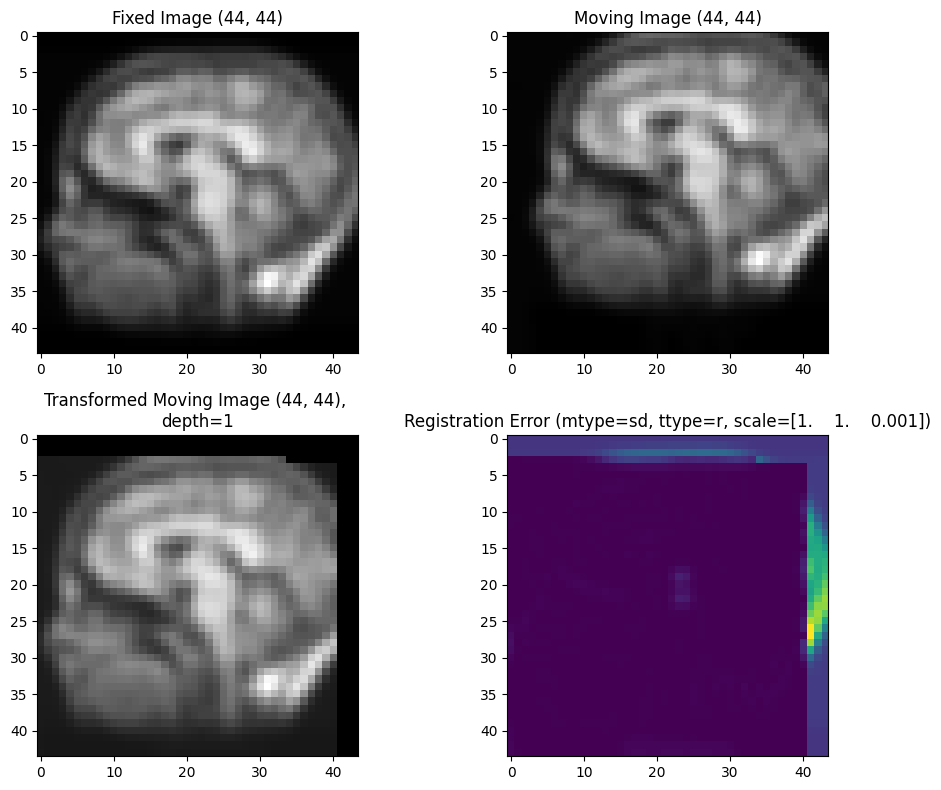

Parameters: [ 5.51290557e+00 -5.96687707e+00  1.50754715e-03]


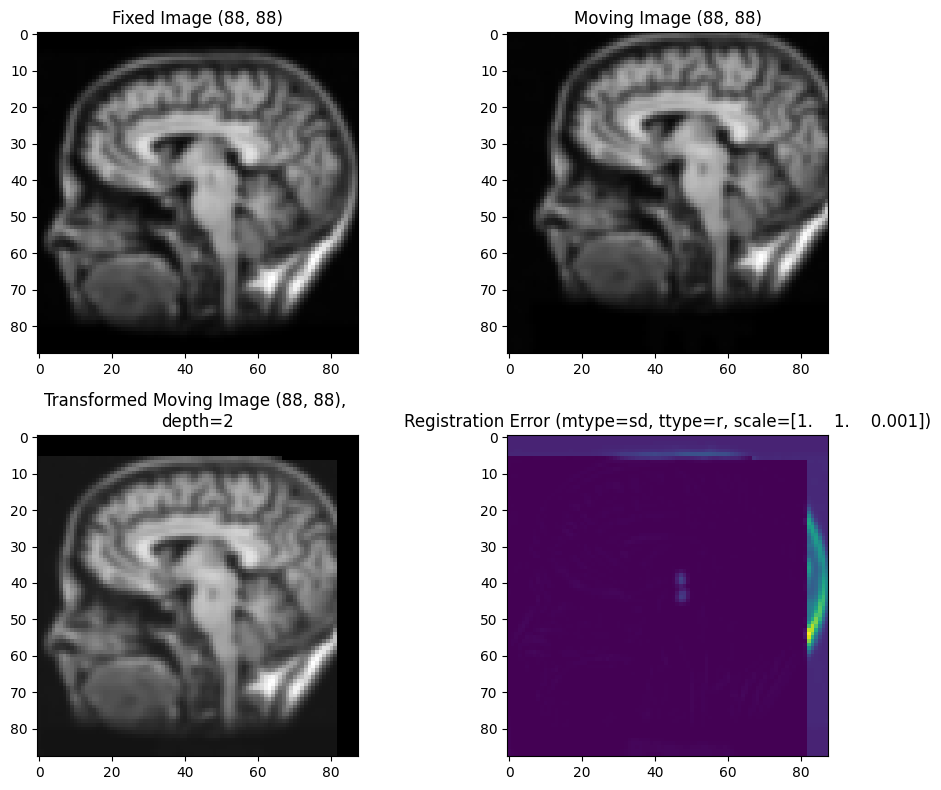

Parameters: [ 1.09520617e+01 -1.19383235e+01  1.50324665e-03]


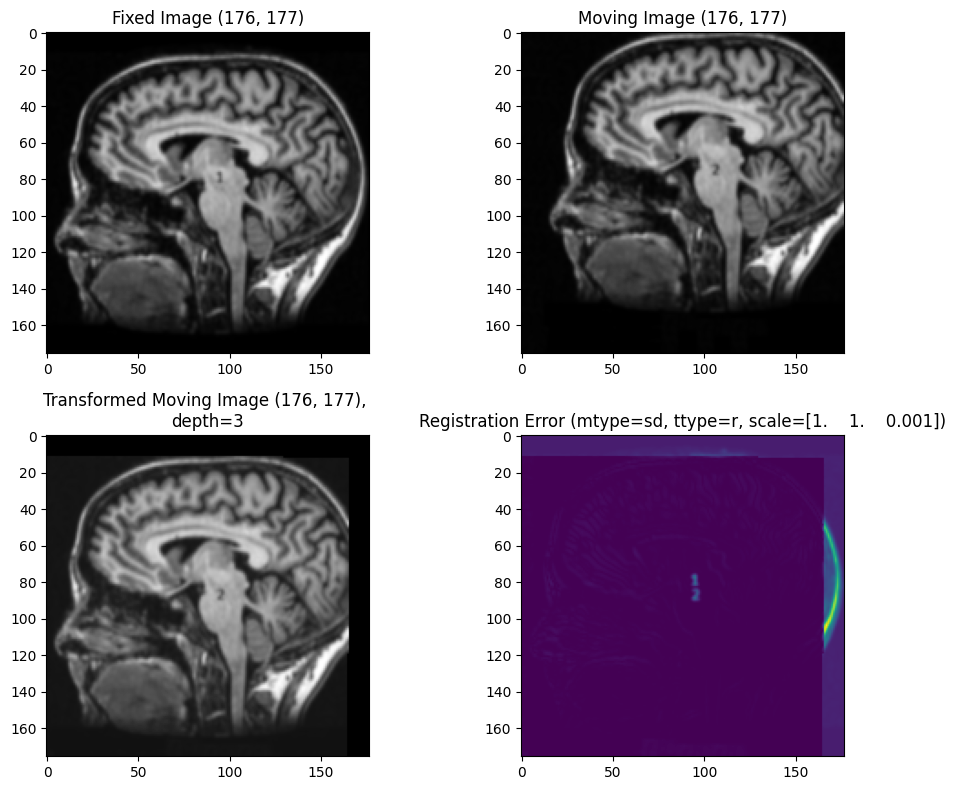

Parameters: [ 2.19153866e+01 -2.39043731e+01  1.49911960e-03]


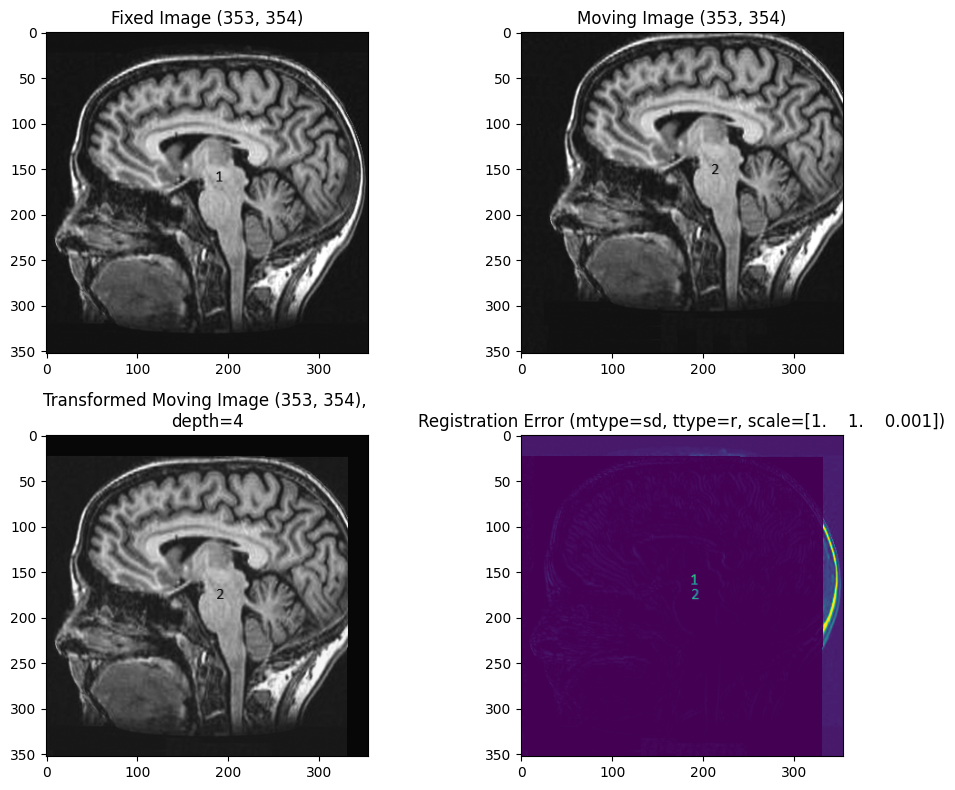


Registration took 6 sec.


In [65]:
import datetime

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain2.png", "brain1.png", 'sd', 'r', tscale=[1, 1, 0.001], multi_scale_depth=4) #, multi_scale_depth=1, 'sd' ,'r', tscale=[1, 1, 0.001]
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# [ 2.18970320e+01 -2.39967496e+01 -1.83637574e-05]
# [ 2.18970320e+01 -2.39967496e+01 -1.83637574e-05]

# Let's add some extra functionality to the framework

**TASK 1**: Add two new similarity metrics to the framework:

1.   Normalized cross-correlation (NCC)
2.   Normalized gradient correlation (NGC)

In [8]:
# The implementation has been moved above to be able to call the implemented functions in the framework
# ncc, grad, and ngc functions

In [9]:
print("------------------------ (Negative) NCC Testing ------------------------")
# Testing the above functions
img1 = rgb2gray(imread("brain2.png")[:,:,0:3]).astype(np.double)
img2 = rgb2gray(imread("brain1.png")[:,:,0:3]).astype(np.double)

# calc using our ncc function
result1 = ncc(img1, img1, negative=False)
result2 = ncc(img1, img2, negative=False)

print(f"Implementation \t result 1: {result1}, result 2: {result2}")

# assertion with expected results
# assert result1 == 1.0, f"Error in implementation. (Negative) NCC should equal to 1.0 as it is the same image. NCC equals {result1}"
# assert result2 != 1.0, f"Error in implementation. (Negative) NCC should not be equal to 1.0 as they are different images. NCC equals {result2}"

# comparing to opencv implementation
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)
cv_result1 = np.max(cv2.matchTemplate(img1, img1, cv2.TM_CCOEFF_NORMED))
cv_result2 = np.max(cv2.matchTemplate(img1, img2, cv2.TM_CCOEFF_NORMED))

# Print the results
print(f"OpenCV  \t result 1: {cv_result1}, result 2: {cv_result2}")


print("\n------------------------ (Negative) NGC Testing ------------------------")
# Testing the above functions
img1 = rgb2gray(imread("brain1.png")[:,:,0:3]).astype(np.double)
img2 = rgb2gray(imread("brain2.png")[:,:,0:3]).astype(np.double)

ngc_result_1 = ngc(img1, img1, negative=False)
ngc_result_2 = ngc(img1, img2, negative=False)

# print(ngc_result_1.shape, type(ngc_result_1))

print("(Negative) Normalized Gradient Correlation (NGC) Result on Identical Images:", ngc_result_1)
print("(Negative) Normalized Gradient Correlation (NGC) Result on Different Images:", ngc_result_2)


# TODO ASK: Shouldn't we change the sign for those new metrics? Since we are minimizing


------------------------ (Negative) NCC Testing ------------------------
Implementation 	 result 1: 1.0, result 2: 0.4049985874003352
OpenCV  	 result 1: 1.0, result 2: 0.4049985110759735

------------------------ (Negative) NGC Testing ------------------------
(Negative) Normalized Gradient Correlation (NGC) Result on Identical Images: 1.0
(Negative) Normalized Gradient Correlation (NGC) Result on Different Images: -0.005883488534430424


**TASK 2**: Modify the framework to be able to deal with full affine 2D transformations.
   - **QUESTION 4**: Justify how you initialize the transformation.

*Your answer here*



C:\Users\abdal\AppData\Local\Temp\ipykernel_50872\2102139461.py:17: RuntimeWarning: invalid value encountered in scalar divide
  result = num / denum


Parameters: [-0.7748966  -0.50545181 -0.19618631  0.79238358  0.79584381 -0.10279957
  0.10469563]


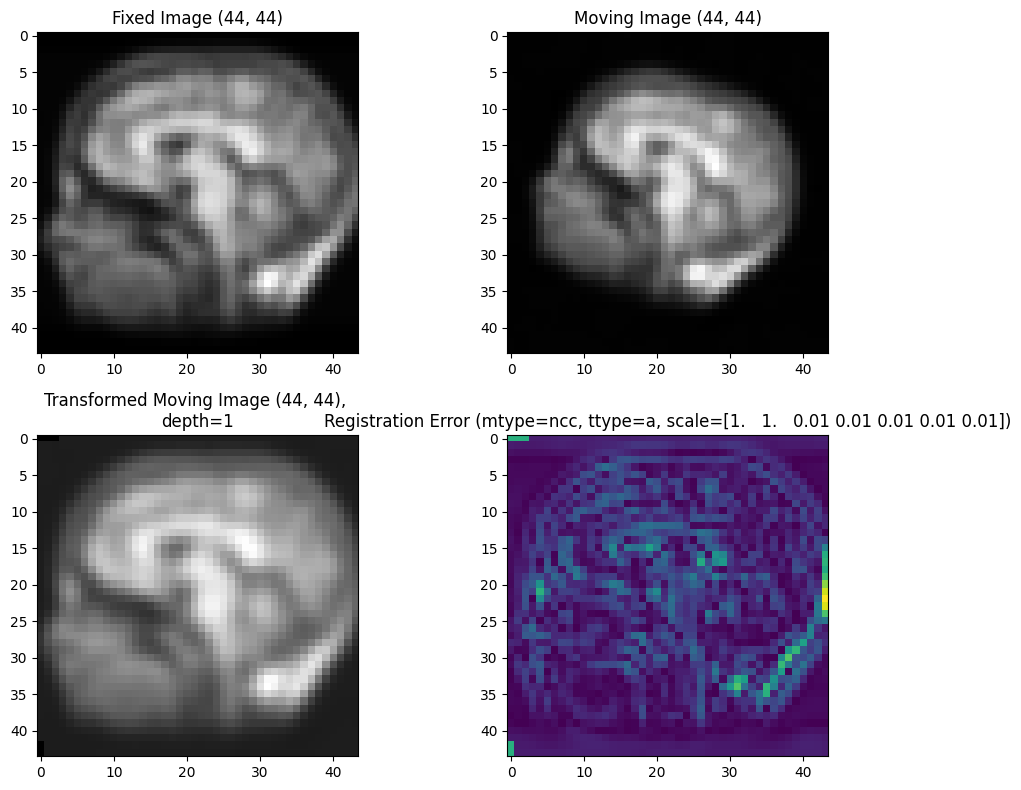

Parameters: [-1.29178264 -1.01308443 -0.19676636  0.79549518  0.79551317 -0.10399135
  0.10429056]


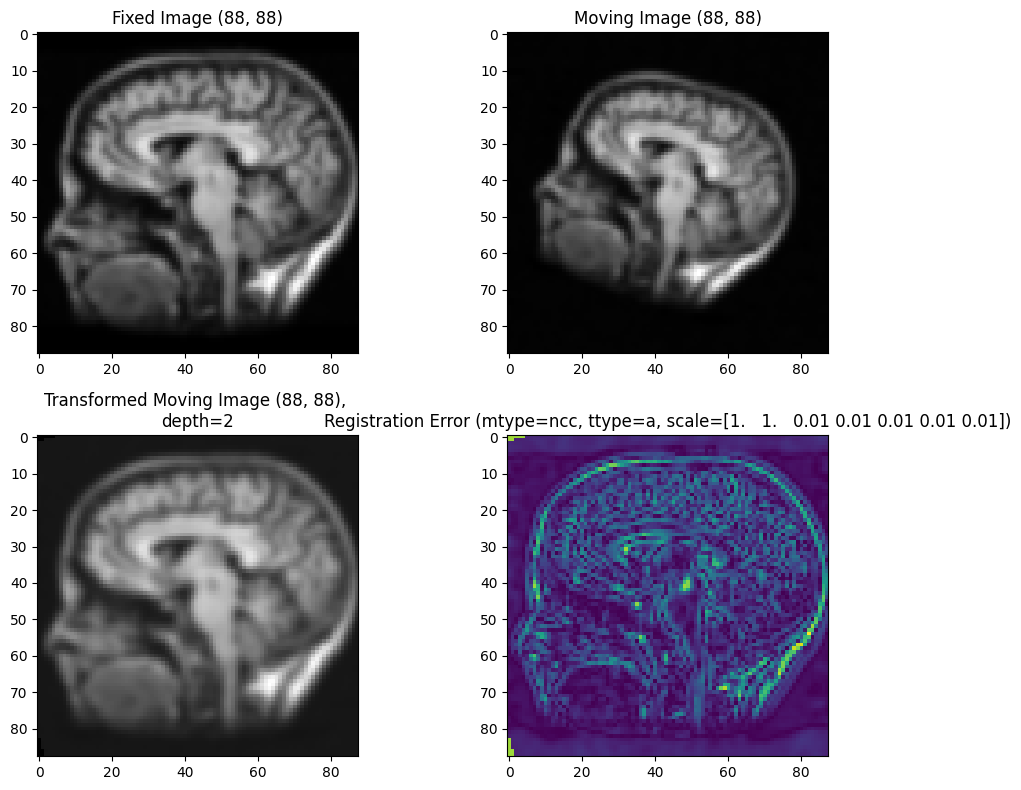

Parameters: [-2.4635048  -1.90646364 -0.19676062  0.79574818  0.79570021 -0.10414085
  0.10416139]


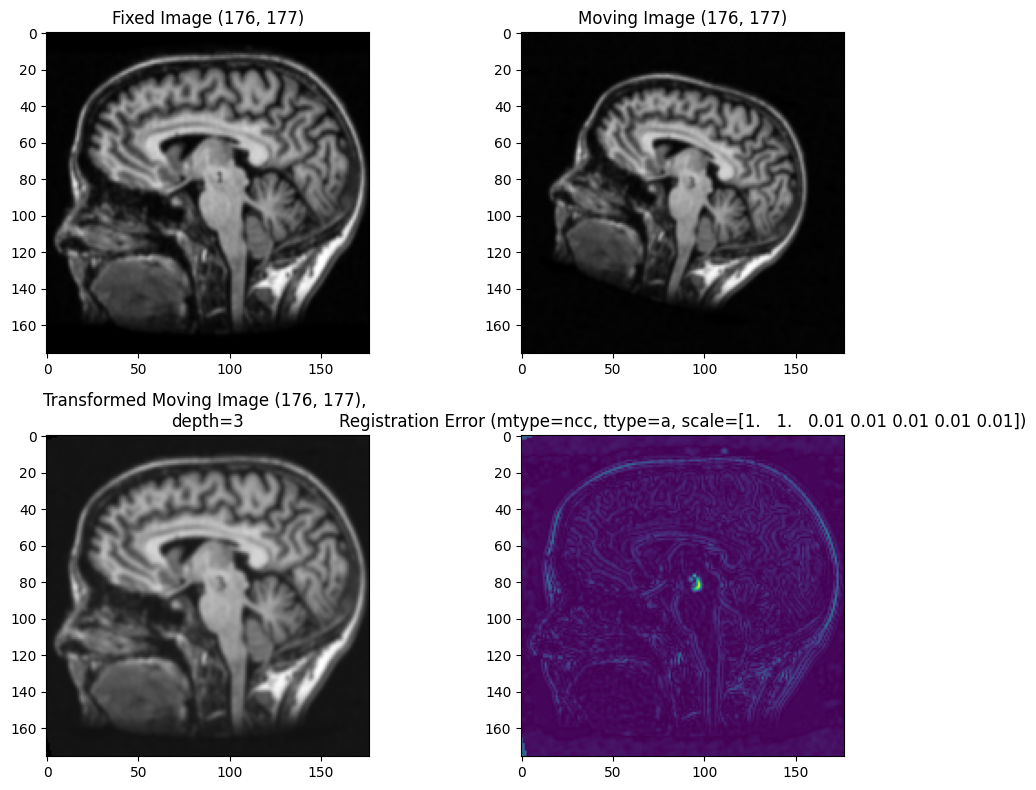

Parameters: [-4.80941623 -3.93004867 -0.19677212  0.79575927  0.7957365  -0.10415826
  0.10414691]


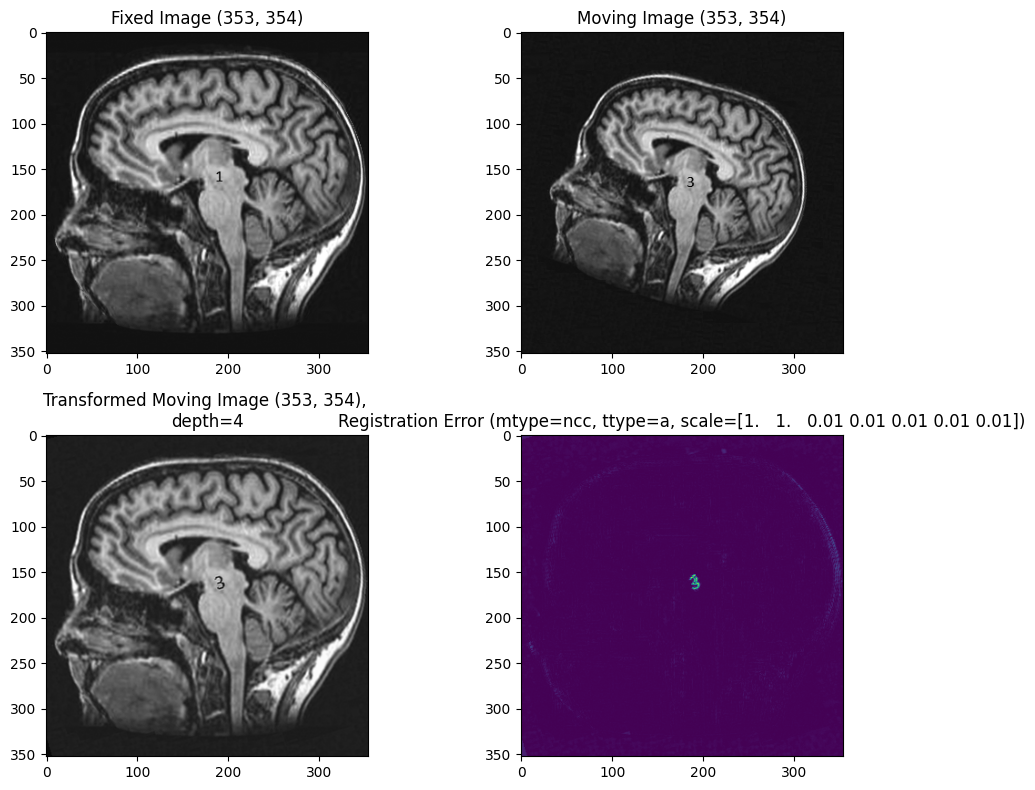


Registration took 5 sec.


In [70]:
# Running full affine 2D transformation with SD matric

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain3.png", "brain1.png", 'ncc', 'a', tscale=[1, 1, 0.01, 0.01, 0.01, 0.01, 0.01], multi_scale_depth=4) # experiment different scales
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')



**TASK 3**: Implement the above modifications in a multi-resolution registration framework. The number of resolutions should be a parameter of the framework.
  - **QUESTION 5**: Discuss how each resolution is initialized.
  - **QUESTION 6**: Justify the benefits of multi-resolution in terms of computation time and/or accuracy of the final result, compared to a single resolution.

*Your answers here*



Text(0.5, 1.0, 'Moving Image (88, 88)')

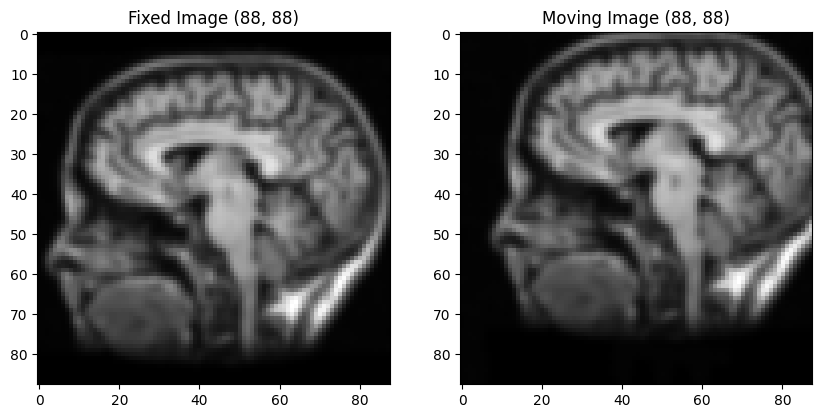

In [19]:
 
# Implementation for multi-resolution function that retuns a pyramid of images, both fixed and moving into 2 separate lists, and a scaling factor
# The implementation is moved to above cells for this function and used called, here is only for demonestration
Imoving = rgb2gray(imread("brain2.png")[:,:,0:3]).astype(np.double)
Ifixed = rgb2gray(imread("brain1.png")[:,:,0:3]).astype(np.double)

Imoving_list, Ifixed_list, scale_factor = create_multi_resolution_pyramid(Imoving, Ifixed, depth=4)

# Show the registration results
plt.figure(figsize=(10, 8))

view_depth_index = 1  # Only for visual debugging, no visual debugging if depth is 1 (1 level), the index must be equal to 0

plt.subplot(1, 2, 1)
plt.imshow(Ifixed_list[view_depth_index], cmap='gray')
plt.title(f'Fixed Image {Ifixed_list[view_depth_index].shape}')

plt.subplot(1, 2, 2)
plt.imshow(Imoving_list[view_depth_index], cmap='gray')
plt.title(f'Moving Image {Imoving_list[view_depth_index].shape}')

# Let's try your implementation

**TASK 4**: Show some registration results using brain1.png, brain2.png, brain3.png, and brain4.png with the different combinations of the registration framework: different <u>metrics</u>, <u>transformations</u> and <u>multi-resolution levels</u>.



Parameters: [0. 0. 0. 1. 1. 0. 0.]


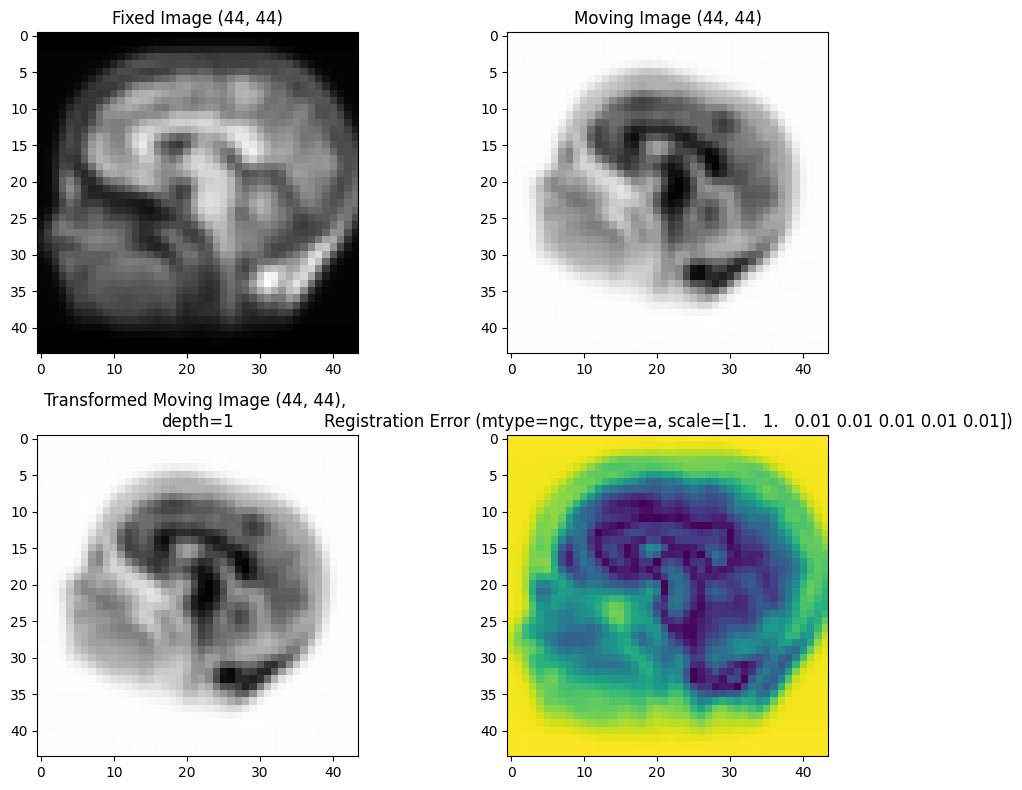

Parameters: [0. 0. 0. 1. 1. 0. 0.]


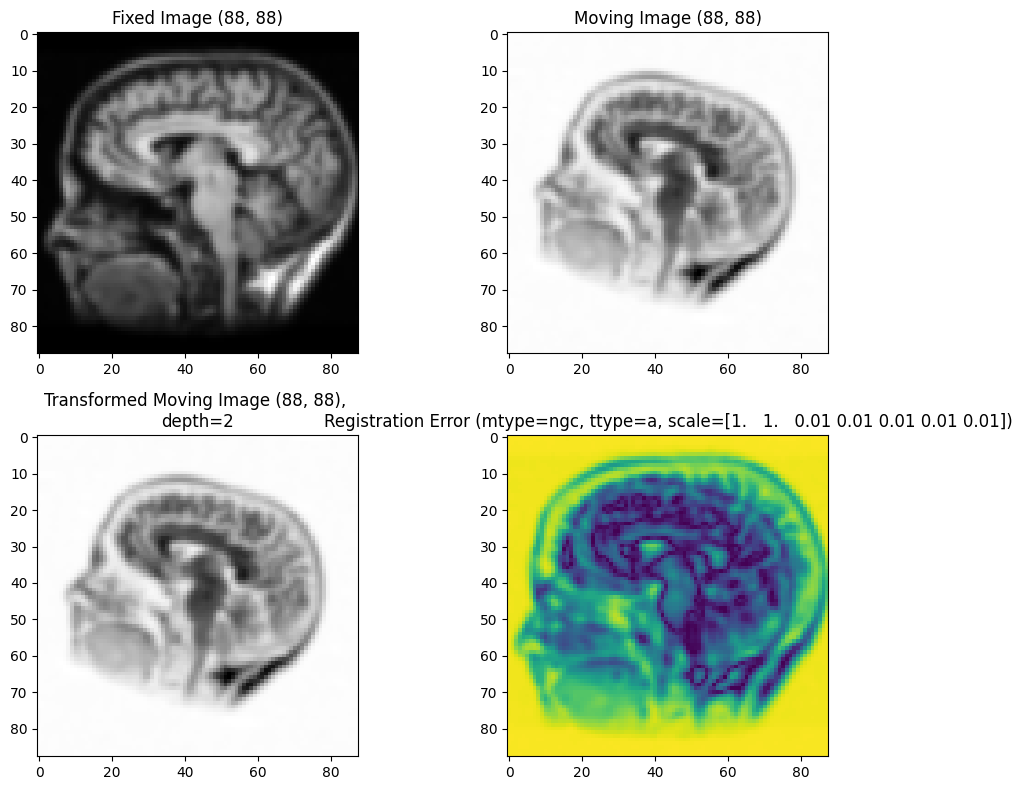

Parameters: [-8.57977588e-02  1.03618549e-02  1.28397180e-06  9.99355540e-01
  1.00022460e+00 -1.39856968e-04  1.12534629e-04]


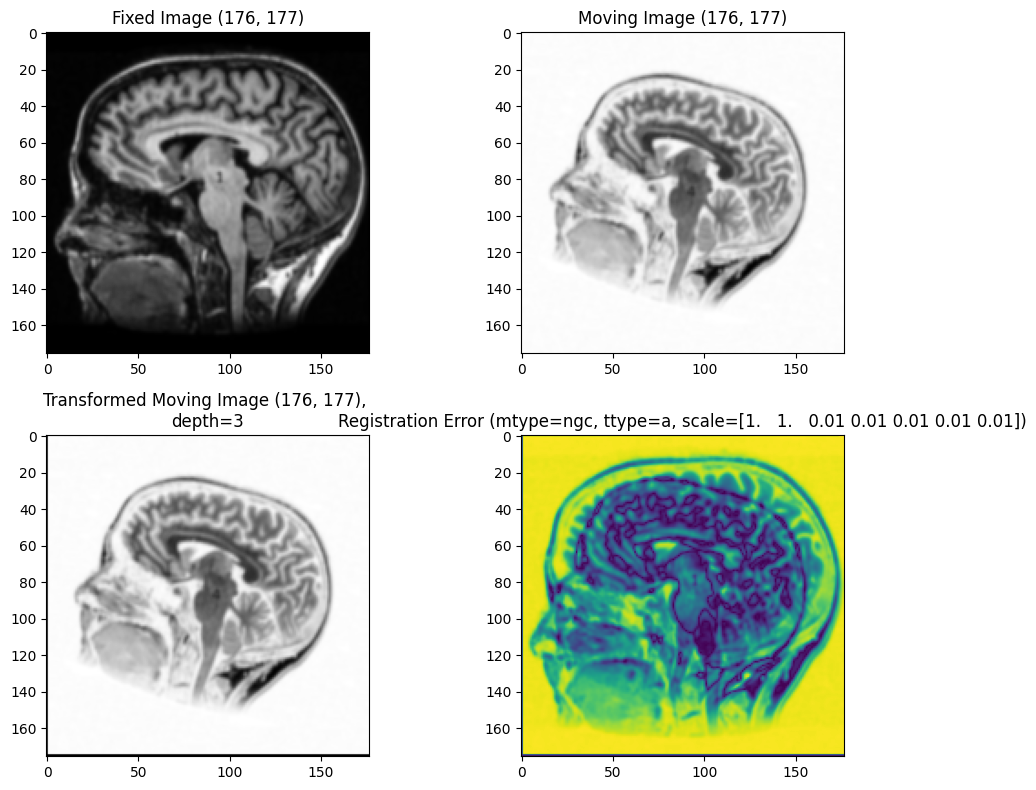

Parameters: [ 8.10650826e-01 -4.83449211e+00 -1.17101991e-02  1.00847418e+00
  9.53607315e-01  1.99557435e-03 -5.02434673e-02]


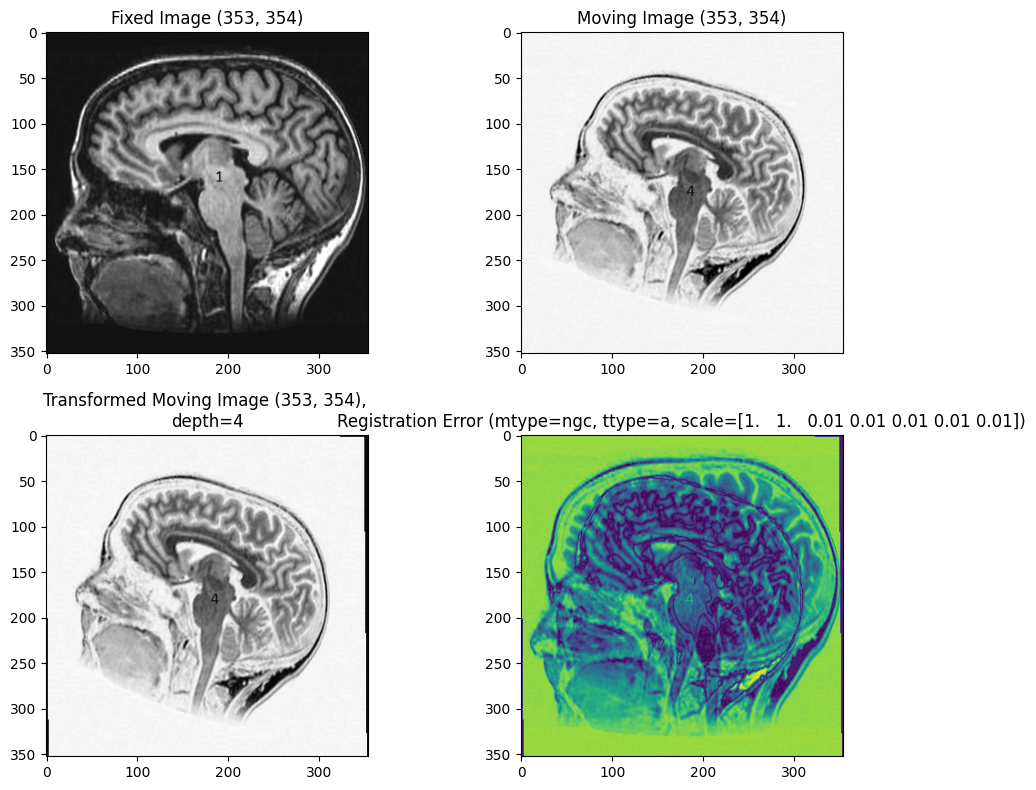


Registration took 21 sec.


In [73]:
#Your code here

# Running full affine 2D transformation with SD matric

start = datetime.datetime.now()
Iregistered, transformation_matrix = affineReg2D("brain4.png", "brain1.png", 'ngc', 'a', tscale=[1, 1, 0.01, 0.01, 0.01, 0.01, 0.01], multi_scale_depth=4) # experiment different scales
end = datetime.datetime.now()

print(f'\nRegistration took {(end-start).seconds} sec.')

# Parameters: [ 0.00000000e+00  0.00000000e+00 -6.18991421e-14  9.95763392e-01  1.14918197e+00  0.00000000e+00  0.00000000e+00]

**TASK 5**: For selected (representative) cases, plot the metric against iterations, computation time, registration results and final error (<u>propose a quantitative error measure</u>).

In [ ]:
#Your code here

**QUESTION 7**: Are the results what you were expecting? If not, explain why.

*Your answer here*